## 1. Pendahuluan

Training **Deep Neural Networks** (DNN) menghadapi beberapa tantangan:

- **Vanishing/Exploding Gradients**: Gradients menjadi sangat kecil atau sangat besar
- **Training Data yang Tidak Cukup**: DNN membutuhkan banyak data
- **Training yang Lambat**: Banyak parameters untuk dioptimasi
- **Overfitting**: Model terlalu complex untuk data yang ada

Chapter ini membahas teknik-teknik untuk mengatasi masalah tersebut.

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [5]:
# Load Fashion MNIST untuk eksperimen
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print(f"Training: {X_train.shape}, Validation: {X_valid.shape}, Test: {X_test.shape}")

Training: (55000, 28, 28), Validation: (5000, 28, 28), Test: (10000, 28, 28)


## 2. Vanishing/Exploding Gradients Problem

### Masalah

Pada deep networks, gradients dapat:
- **Vanish**: Menjadi sangat kecil → lower layers tidak belajar
- **Explode**: Menjadi sangat besar → training tidak stabil

### Penyebab:
- Sigmoid/Tanh activation functions saturate
- Weights initialization yang buruk

### Solusi:

1. **Proper Weight Initialization**
2. **Better Activation Functions**
3. **Batch Normalization**

### 2.1 Weight Initialization

| Initialization | Activation Functions | Formula |
|----------------|----------------------|---------|
| **Glorot (Xavier)** | None, Tanh, Sigmoid, Softmax | $\sigma = \sqrt{\frac{2}{fan_{in} + fan_{out}}}$ |
| **He** | ReLU, Leaky ReLU, ELU | $\sigma = \sqrt{\frac{2}{fan_{in}}}$ |
| **LeCun** | SELU | $\sigma = \sqrt{\frac{1}{fan_{in}}}$ |

In [6]:
# Berbagai Weight Initializers di Keras

# Glorot Uniform (default)
glorot_uniform = keras.initializers.GlorotUniform()

# He Normal (untuk ReLU)
he_normal = keras.initializers.HeNormal()

# LeCun Normal (untuk SELU)
lecun_normal = keras.initializers.lecun_normal()

# Contoh penggunaan
layer_with_he = keras.layers.Dense(
    100, 
    activation='relu',
    kernel_initializer='he_normal'  # atau he_normal
)

print("Weight Initializers: GlorotUniform, GlorotNormal, HeUniform, HeNormal, LeCunNormal")

Weight Initializers: GlorotUniform, GlorotNormal, HeUniform, HeNormal, LeCunNormal


### 2.2 Activation Functions yang Lebih Baik

| Activation | Formula | Keunggulan | Kekurangan |
|------------|---------|------------|------------|
| **ReLU** | $\max(0, z)$ | Simple, fast | "Dying ReLU" problem |
| **Leaky ReLU** | $\max(\alpha z, z)$ | Tidak ada dying neurons | Extra hyperparameter |
| **ELU** | $\alpha(e^z - 1)$ if $z < 0$ | Smooth, mean output ≈ 0 | Slower to compute |
| **SELU** | Self-normalizing | Auto-normalization | Specific constraints |
| **Swish** | $z \cdot \sigma(z)$ | Often outperforms ReLU | Slower |

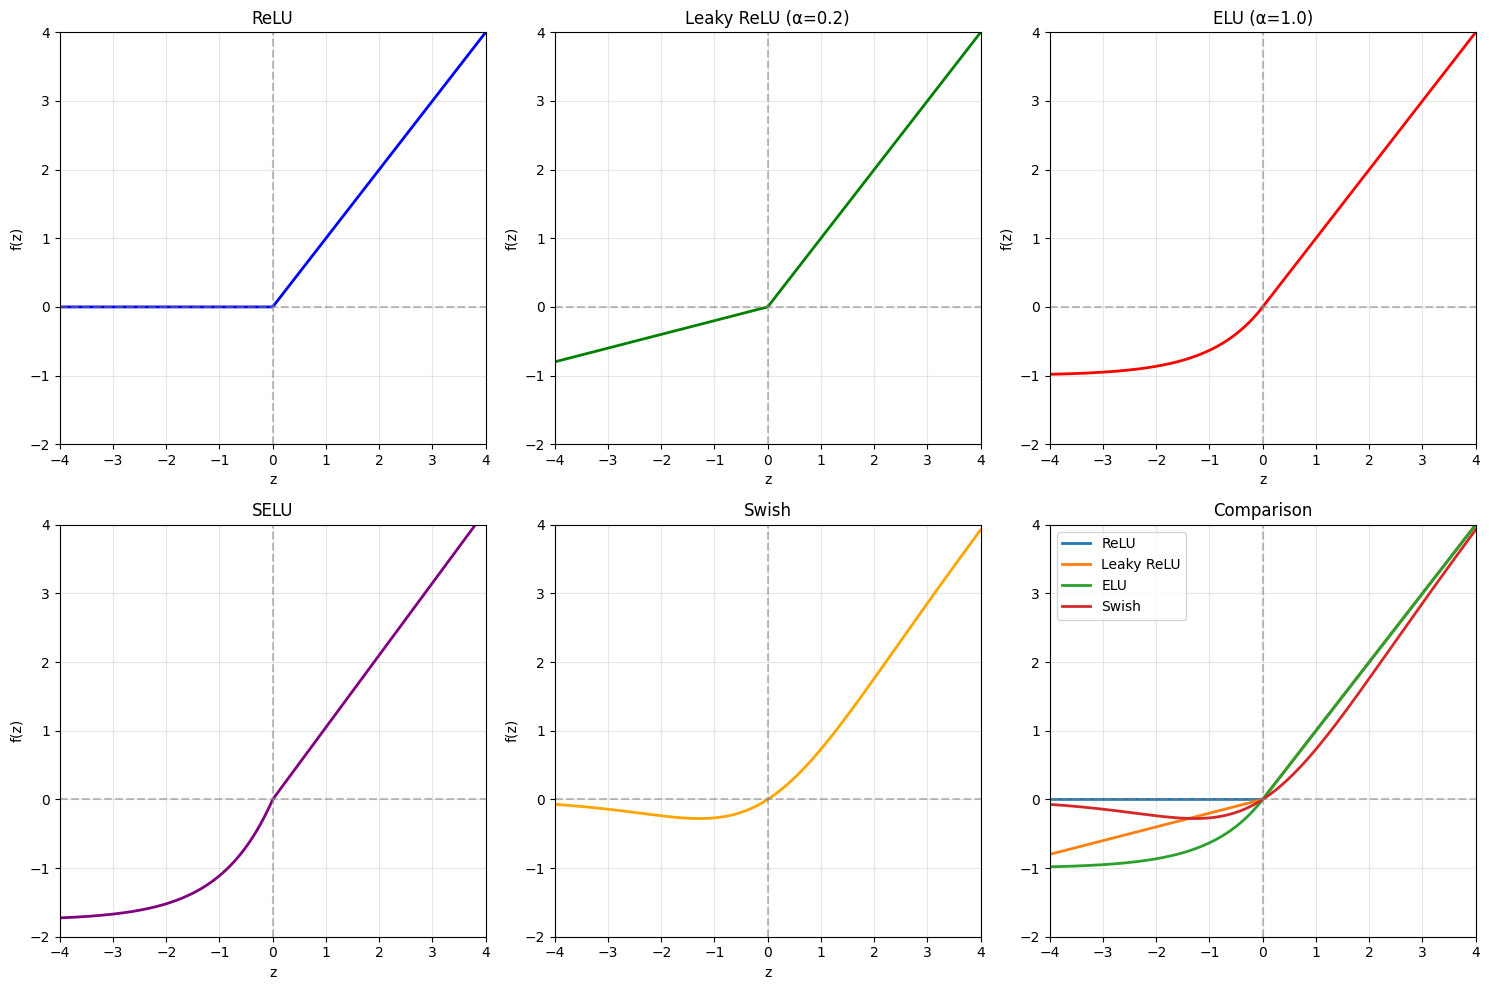

In [7]:
# Visualisasi Activation Functions
z = np.linspace(-4, 4, 200)

# Activation functions
relu = np.maximum(0, z)
leaky_relu = np.where(z > 0, z, 0.2 * z)  # alpha = 0.2
elu = np.where(z > 0, z, 1.0 * (np.exp(z) - 1))  # alpha = 1.0
selu_scale = 1.0507009873554804934193349852946
selu_alpha = 1.6732632423543772848170429916717
selu = selu_scale * np.where(z > 0, z, selu_alpha * (np.exp(z) - 1))
swish = z * (1 / (1 + np.exp(-z)))  # z * sigmoid(z)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

activations = [
    (relu, 'ReLU', 'blue'),
    (leaky_relu, 'Leaky ReLU (α=0.2)', 'green'),
    (elu, 'ELU (α=1.0)', 'red'),
    (selu, 'SELU', 'purple'),
    (swish, 'Swish', 'orange')
]

for ax, (func, name, color) in zip(axes.flat[:5], activations):
    ax.plot(z, func, color=color, linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('z')
    ax.set_ylabel('f(z)')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-2, 4)

# Comparison plot
axes[1, 2].plot(z, relu, label='ReLU', linewidth=2)
axes[1, 2].plot(z, leaky_relu, label='Leaky ReLU', linewidth=2)
axes[1, 2].plot(z, elu, label='ELU', linewidth=2)
axes[1, 2].plot(z, swish, label='Swish', linewidth=2)
axes[1, 2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 2].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 2].set_title('Comparison', fontsize=12)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xlim(-4, 4)
axes[1, 2].set_ylim(-2, 4)

plt.tight_layout()
plt.show()

In [8]:
# Menggunakan berbagai activation functions di Keras

# Model dengan Leaky ReLU
model_leaky = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(negative_slope=0.2),  # Leaky ReLU sebagai layer
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(10, activation='softmax')
])

print("Model dengan Leaky ReLU:")
model_leaky.summary()

Model dengan Leaky ReLU:


C:\Users\HP Pavilion 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model dengan SELU (Self-Normalizing)
# SELU memerlukan: lecun_normal initializer dan input normalization

model_selu = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation='softmax')
])

print("\nModel dengan SELU (Self-Normalizing Neural Network):")
model_selu.summary()


Model dengan SELU (Self-Normalizing Neural Network):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### 2.3 Batch Normalization

**Batch Normalization** menormalisasi input ke setiap layer, mengurangi masalah vanishing/exploding gradients.

**Algoritma:**

1. Hitung mean dan variance dari mini-batch:
   - $\mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} x^{(i)}$
   - $\sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (x^{(i)} - \mu_B)^2$

2. Normalize: $\hat{x}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$

3. Scale dan shift: $z^{(i)} = \gamma \hat{x}^{(i)} + \beta$

**Keuntungan:**
- Mengurangi vanishing/exploding gradients
- Memungkinkan learning rate yang lebih tinggi
- Bertindak sebagai regularizer
- Mengurangi ketergantungan pada weight initialization

In [10]:
# Model dengan Batch Normalization
model_bn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

model_bn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [11]:
# Batch Normalization SEBELUM activation (alternatif)
model_bn_before = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')
])

print("Batch Normalization sebelum activation:")
model_bn_before.summary()

Batch Normalization sebelum activation:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 300)            │       235,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,810 (1.02 MB)

 Trainable params: 267,010 (1.02 MB)

 Non-trainable params: 800 (3.12 KB)

In [12]:
# Training model dengan Batch Normalization
model_bn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

history_bn = model_bn.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=1
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8005 - loss: 0.5664 - val_accuracy: 0.8650 - val_loss: 0.3870
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8577 - loss: 0.4009 - val_accuracy: 0.8756 - val_loss: 0.3564
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8762 - loss: 0.3504 - val_accuracy: 0.8794 - val_loss: 0.3416
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8890 - loss: 0.3148 - val_accuracy: 0.8836 - val_loss: 0.3338
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8998 - loss: 0.2856 - val_accuracy: 0.8864 - val_loss: 0.3303
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9098 - loss: 0.2598 - val_accuracy: 0.8852 - val_loss: 0.3303
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9185 - loss: 0.2364 - val_accuracy: 0.8848 - val_loss: 0.3324
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9272 - loss: 0.2147 - 

## 3. Reusing Pretrained Layers (Transfer Learning)

**Transfer Learning** menggunakan model yang sudah dilatih untuk task serupa.

### Keuntungan:
- Training lebih cepat
- Membutuhkan lebih sedikit data
- Performa lebih baik

### Strategi:
1. **Feature Extraction**: Freeze semua pretrained layers, train hanya output layer
2. **Fine-tuning**: Unfreeze beberapa top layers, train dengan learning rate kecil

In [13]:
# Contoh Transfer Learning

# 1. Load pretrained model (contoh: model yang sudah dilatih sebelumnya)
# Simulasi: kita train model A terlebih dahulu

model_A = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu', name='dense_1'),
    keras.layers.Dense(100, activation='relu', name='dense_2'),
    keras.layers.Dense(50, activation='relu', name='dense_3'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

# Train model A
model_A.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=1)

# Save model A
# model_A.save('model_A.keras')

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7464 - loss: 0.7637 - val_accuracy: 0.8182 - val_loss: 0.5374
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8290 - loss: 0.4846 - val_accuracy: 0.8452 - val_loss: 0.4471
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8459 - loss: 0.4346 - val_accuracy: 0.8620 - val_loss: 0.4076
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8563 - loss: 0.4050 - val_accuracy: 0.8676 - val_loss: 0.3858
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8634 - loss: 0.3831 - val_accuracy: 0.8726 - val_loss: 0.3689


In [14]:
# 2. Membuat model B menggunakan layers dari model A

# Clone model A tanpa output layer
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# Buat model B dengan reusing layers
model_B = keras.models.Sequential(model_A_clone.layers[:-1])  # Semua kecuali output
model_B.add(keras.layers.Dense(5, activation='softmax', name='new_output'))  # Output baru

model_B.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_output (Dense)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,650 (1.03 MB)

 Trainable params: 270,650 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 3. Freeze lower layers
for layer in model_B.layers[:-1]:
    layer.trainable = False

# Lihat trainable parameters
print("Trainable status setelah freezing:")
for layer in model_B.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

Trainable status setelah freezing:
flatten_4: trainable = False
dense_1: trainable = False
dense_2: trainable = False
dense_3: trainable = False
new_output: trainable = True


In [16]:
# 4. Compile dan train model B
model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

# Simulasi: gunakan subset data (binary classification: class 0-4)
mask_train = y_train < 5
mask_valid = y_valid < 5

X_train_B = X_train[mask_train]
y_train_B = y_train[mask_train]
X_valid_B = X_valid[mask_valid]
y_valid_B = y_valid[mask_valid]

# Train hanya output layer
history_B = model_B.fit(
    X_train_B, y_train_B,
    epochs=5,
    validation_data=(X_valid_B, y_valid_B),
    verbose=1
)

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8677 - loss: 0.4234 - val_accuracy: 0.8919 - val_loss: 0.3136
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8925 - loss: 0.3056 - val_accuracy: 0.8986 - val_loss: 0.3005
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8949 - loss: 0.2966 - val_accuracy: 0.8986 - val_loss: 0.2964
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.2928 - val_accuracy: 0.8982 - val_loss: 0.2944
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8969 - loss: 0.2908 - val_accuracy: 0.8966 - val_loss: 0.2933


In [17]:
# 5. Fine-tuning: unfreeze beberapa top layers
for layer in model_B.layers[-2:]:  # Unfreeze 2 layers terakhir
    layer.trainable = True

# Recompile dengan learning rate lebih kecil
model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),  # Smaller LR
    metrics=['accuracy']
)

# Fine-tune
history_fine = model_B.fit(
    X_train_B, y_train_B,
    epochs=5,
    validation_data=(X_valid_B, y_valid_B),
    verbose=1
)

print("\nFine-tuning selesai!")

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8967 - loss: 0.2881 - val_accuracy: 0.8982 - val_loss: 0.2916
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8969 - loss: 0.2877 - val_accuracy: 0.8982 - val_loss: 0.2914
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8967 - loss: 0.2873 - val_accuracy: 0.8978 - val_loss: 0.2912
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8967 - loss: 0.2869 - val_accuracy: 0.8978 - val_loss: 0.2910
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8969 - loss: 0.2865 - val_accuracy: 0.8974 - val_loss: 0.2908

Fine-tuning selesai!


## 4. Faster Optimizers

Optimizer yang lebih baik dari vanilla SGD dapat mempercepat training.

### 4.1 Momentum Optimization

Menambahkan "momentum" untuk mempercepat konvergensi.

$$\mathbf{m} \leftarrow \beta \mathbf{m} - \eta \nabla_\theta J(\theta)$$
$$\theta \leftarrow \theta + \mathbf{m}$$

- $\beta$ = momentum (biasanya 0.9)
- Seperti bola yang menggelinding menuruni bukit

In [18]:
# SGD with Momentum
optimizer_momentum = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Nesterov Accelerated Gradient (NAG)
optimizer_nag = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

print("Momentum dan Nesterov mempercepat konvergensi")

Momentum dan Nesterov mempercepat konvergensi


### 4.2 AdaGrad, RMSprop, dan Adam

| Optimizer | Karakteristik | Kapan Digunakan |
|-----------|---------------|------------------|
| **AdaGrad** | Adaptive learning rate per parameter | Sparse features |
| **RMSprop** | Fixes AdaGrad's diminishing LR | RNNs |
| **Adam** | Combines momentum + RMSprop | Default choice |
| **AdamW** | Adam with weight decay | Better generalization |

In [19]:
# Berbagai Optimizers

# RMSprop
optimizer_rmsprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# Adam (Adaptive Moment Estimation)
optimizer_adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# AdamW (Adam with Weight Decay)
optimizer_adamw = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)

# Nadam (Adam + Nesterov)
optimizer_nadam = keras.optimizers.Nadam(learning_rate=0.001)

print("Optimizers tersedia: SGD, Momentum, RMSprop, Adam, AdamW, Nadam")

Optimizers tersedia: SGD, Momentum, RMSprop, Adam, AdamW, Nadam


In [20]:
# Perbandingan Optimizers
def create_model():
    return keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

optimizers_to_test = {
    'SGD': keras.optimizers.SGD(learning_rate=0.01),
    'Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
}

histories = {}

for name, opt in optimizers_to_test.items():
    print(f"\nTraining with {name}...")
    model = create_model()
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    histories[name] = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_valid, y_valid),
        verbose=0
    )
    print(f"{name} - Val Accuracy: {histories[name].history['val_accuracy'][-1]:.4f}")


Training with SGD...
SGD - Val Accuracy: 0.8786

Training with Momentum...
Momentum - Val Accuracy: 0.8880

Training with Adam...
Adam - Val Accuracy: 0.8942


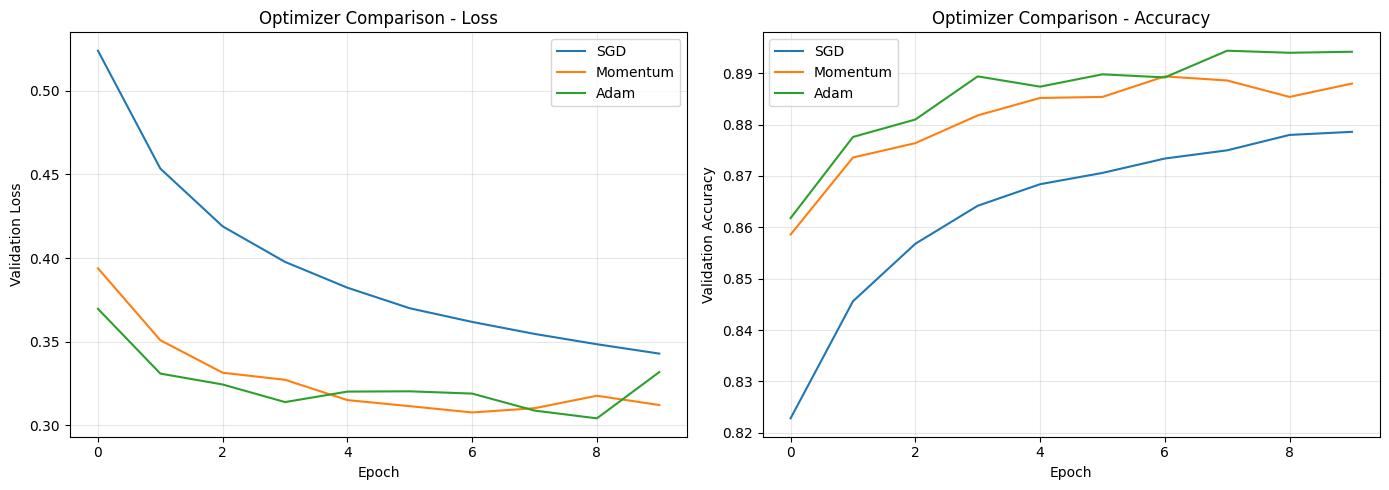

In [21]:
# Plot perbandingan optimizers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, history in histories.items():
    axes[0].plot(history.history['val_loss'], label=name)
    axes[1].plot(history.history['val_accuracy'], label=name)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Optimizer Comparison - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Optimizer Comparison - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Learning Rate Scheduling

Mengubah learning rate selama training untuk hasil optimal.

**Strategi:**
- **Power Scheduling**: $\eta(t) = \frac{\eta_0}{(1 + t/s)^c}$
- **Exponential Scheduling**: $\eta(t) = \eta_0 \cdot 0.1^{t/s}$
- **Piecewise Constant**: Turunkan LR pada epoch tertentu
- **1cycle**: Increase then decrease
- **Performance Scheduling**: Turunkan jika validation loss stagnan

In [22]:
# Learning Rate Schedules

# 1. Exponential Decay
lr_schedule_exp = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)

# 2. Piecewise Constant
lr_schedule_piece = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5000, 10000],
    values=[0.01, 0.005, 0.001]
)

# 3. ReduceLROnPlateau (callback)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("Learning Rate Schedules tersedia!")

Learning Rate Schedules tersedia!


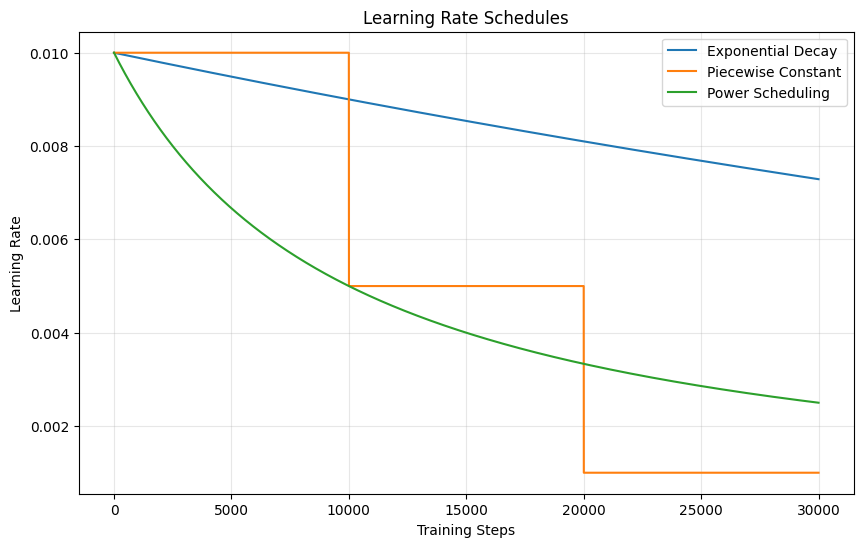

In [23]:
# Visualisasi Learning Rate Schedules
steps = np.arange(0, 30000)

# Exponential decay
lr_exp = 0.01 * (0.9 ** (steps / 10000))

# Piecewise constant
lr_piece = np.where(steps < 10000, 0.01, np.where(steps < 20000, 0.005, 0.001))

# Power scheduling
lr_power = 0.01 / (1 + steps / 10000)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(steps, lr_exp, label='Exponential Decay')
ax.plot(steps, lr_piece, label='Piecewise Constant')
ax.plot(steps, lr_power, label='Power Scheduling')
ax.set_xlabel('Training Steps')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedules')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [24]:
# Model dengan Learning Rate Schedule
model_lr = create_model()

optimizer_with_schedule = keras.optimizers.SGD(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=1000,
        decay_rate=0.96
    )
)

model_lr.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer_with_schedule,
    metrics=['accuracy']
)

history_lr = model_lr.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=1
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7634 - loss: 0.7308 - val_accuracy: 0.8208 - val_loss: 0.5283
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8275 - loss: 0.4935 - val_accuracy: 0.8436 - val_loss: 0.4610
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8425 - loss: 0.4490 - val_accuracy: 0.8502 - val_loss: 0.4293
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8519 - loss: 0.4227 - val_accuracy: 0.8572 - val_loss: 0.4083
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8581 - loss: 0.4040 - val_accuracy: 0.8610 - val_loss: 0.3946
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8633 - loss: 0.3894 - val_accuracy: 0.8654 - val_loss: 0.3833
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8672 - loss: 0.3775 - val_accuracy: 0.8672 - val_loss: 0.3741
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8709 - loss: 0.3675 - 

## 5. Regularization Techniques

Regularization mencegah **overfitting** pada neural networks.

### 5.1 L1 dan L2 Regularization

Menambahkan penalty pada loss function:

- **L2 (Ridge)**: $J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n} \theta_i^2$
- **L1 (Lasso)**: $J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n} |\theta_i|$

In [25]:
# L2 Regularization
from tensorflow.keras import regularizers

model_l2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(100, activation='relu',
                       kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(10, activation='softmax')
])

model_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Model dengan L2 Regularization:")
model_l2.summary()

Model dengan L2 Regularization:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Dropout

**Dropout** secara random "mematikan" sebagian neurons selama training.

- **Rate**: Probabilitas neuron di-drop (biasanya 0.2-0.5)
- Membuat network lebih robust
- Efek ensemble dari banyak subnetworks

In [26]:
# Model dengan Dropout
model_dropout = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.2),  # Dropout di input
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dropout(0.3),  # Dropout setelah hidden layer
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

model_dropout.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Model dengan Dropout:")
model_dropout.summary()

Model dengan Dropout:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training model dengan dropout
history_dropout = model_dropout.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    verbose=1
)

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7735 - loss: 0.6303 - val_accuracy: 0.8506 - val_loss: 0.4075
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8275 - loss: 0.4764 - val_accuracy: 0.8594 - val_loss: 0.3894
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8370 - loss: 0.4430 - val_accuracy: 0.8728 - val_loss: 0.3483
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8452 - loss: 0.4216 - val_accuracy: 0.8694 - val_loss: 0.3491
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8501 - loss: 0.4069 - val_accuracy: 0.8820 - val_loss: 0.3260
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8555 - loss: 0.3953 - val_accuracy: 0.8808 - val_loss: 0.3273
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8583 - loss: 0.3840 - val_accuracy: 0.8796 - val_loss: 0.3227
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8620 - loss: 0.3764 - 

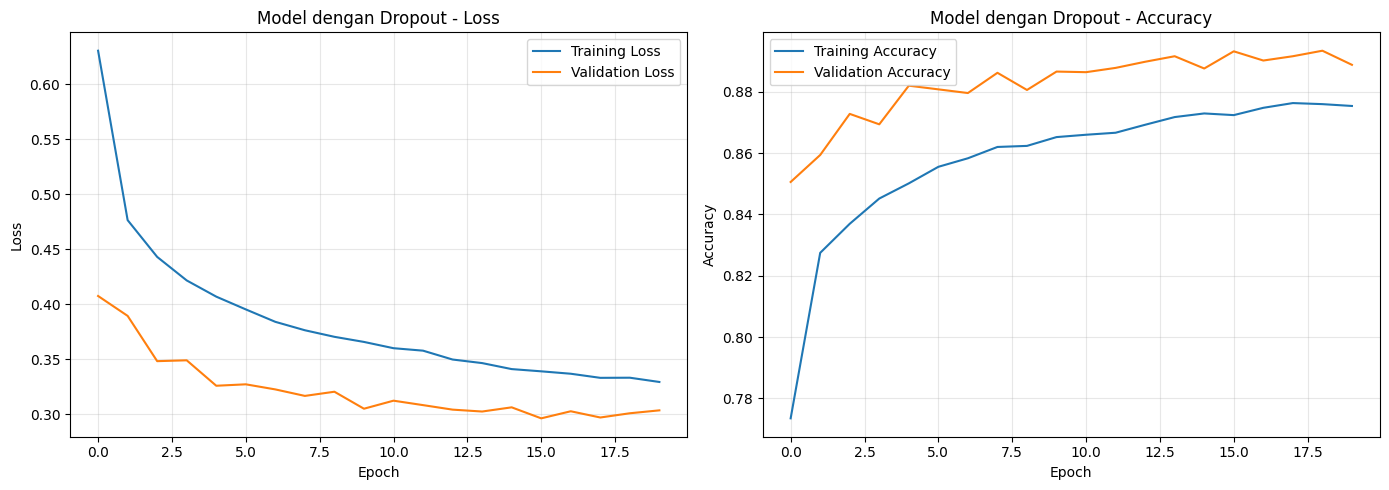

In [28]:
# Visualisasi efek Dropout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_dropout.history['loss'], label='Training Loss')
axes[0].plot(history_dropout.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model dengan Dropout - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_dropout.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_dropout.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model dengan Dropout - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Monte Carlo (MC) Dropout

Menggunakan dropout saat inference untuk mendapatkan uncertainty estimation.

In [29]:
# MC Dropout untuk Uncertainty Estimation
# Gunakan training=True saat prediksi

# Buat beberapa prediksi dengan dropout aktif
n_predictions = 100
X_sample = X_test[:1]  # Satu sample

# Prediksi multiple times
predictions = np.array([
    model_dropout(X_sample, training=True).numpy()
    for _ in range(n_predictions)
])

# Mean dan std dari prediksi
mean_prediction = predictions.mean(axis=0)
std_prediction = predictions.std(axis=0)

print(f"Mean prediction: {mean_prediction.round(3)}")
print(f"Std (uncertainty): {std_prediction.round(3)}")
print(f"Predicted class: {np.argmax(mean_prediction)}")
print(f"Confidence: {mean_prediction.max():.2%}")

Mean prediction: [[0.    0.    0.    0.    0.    0.02  0.    0.082 0.    0.896]]
Std (uncertainty): [[0.    0.    0.    0.001 0.    0.044 0.    0.115 0.002 0.13 ]]
Predicted class: 9
Confidence: 89.65%


### 5.4 Early Stopping

Menghentikan training ketika validation performance tidak meningkat.

In [30]:
# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Metric yang dipantau
    patience=10,              # Epochs tanpa improvement sebelum stop
    restore_best_weights=True # Kembalikan ke weights terbaik
)

model_es = create_model()
model_es.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_es = model_es.fit(
    X_train, y_train,
    epochs=100,  # Set tinggi, early stopping akan handle
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

print(f"\nTraining stopped at epoch {len(history_es.history['loss'])}")

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8250 - loss: 0.4845 - val_accuracy: 0.8672 - val_loss: 0.3730
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8665 - loss: 0.3635 - val_accuracy: 0.8750 - val_loss: 0.3341
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8790 - loss: 0.3257 - val_accuracy: 0.8854 - val_loss: 0.3192
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8885 - loss: 0.2976 - val_accuracy: 0.8866 - val_loss: 0.3227
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8954 - loss: 0.2783 - val_accuracy: 0.8880 - val_loss: 0.3064
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9018 - loss: 0.2617 - val_accuracy: 0.8856 - val_loss: 0.3222
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9068 - loss: 0.2491 - val_accuracy: 0.8858 - val_loss: 0.3202
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9110 - loss: 0

### 5.5 Max-Norm Regularization

Membatasi magnitude dari weight vectors.

In [31]:
# Max-Norm Regularization
from tensorflow.keras.constraints import MaxNorm

model_maxnorm = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu',
                       kernel_constraint=MaxNorm(max_value=1.0)),
    keras.layers.Dense(100, activation='relu',
                       kernel_constraint=MaxNorm(max_value=1.0)),
    keras.layers.Dense(10, activation='softmax')
])

print("Model dengan Max-Norm Regularization dibuat!")

Model dengan Max-Norm Regularization dibuat!


## 6. Practical Guidelines

### Default Configuration untuk DNN:

| Hyperparameter | Default Value | Notes |
|----------------|---------------|-------|
| **Kernel Initializer** | He Normal | Untuk ReLU variants |
| **Activation (hidden)** | ReLU / Swish | ELU/SELU untuk deep |
| **Activation (output)** | Softmax / Sigmoid | Tergantung task |
| **Normalization** | Batch Norm | Setelah activation |
| **Regularization** | Dropout + Early Stopping | 0.1-0.5 rate |
| **Optimizer** | Adam / AdamW | Nadam untuk training cepat |
| **Learning Rate** | 1e-3 → dengan schedule | Reduce on plateau |

In [32]:
# Model dengan Best Practices
def create_best_practice_model(input_shape, n_classes, n_hidden=2, n_neurons=256):
    """
    Membuat model DNN dengan best practices:
    - He initialization
    - Batch Normalization
    - ReLU activation
    - Dropout regularization
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer='he_normal'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    
    return model

# Buat model
best_model = create_best_practice_model(
    input_shape=[28, 28],
    n_classes=10,
    n_hidden=3,
    n_neurons=256
)

best_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,186 (1.29 MB)

 Trainable params: 336,650 (1.28 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [33]:
# Compile dengan best practices
best_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

# Train
history_best = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7859 - loss: 0.6031 - val_accuracy: 0.8464 - val_loss: 0.4033 - learning_rate: 0.0010
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8364 - loss: 0.4536 - val_accuracy: 0.8552 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8509 - loss: 0.4110 - val_accuracy: 0.8686 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8591 - loss: 0.3834 - val_accuracy: 0.8746 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8657 - loss: 0.3614 - val_accuracy: 0.8760 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8727 - loss: 0.3450 - val_accuracy: 0.8810 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8783 - l

In [34]:
# Evaluasi final model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n=== Final Evaluation ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


=== Final Evaluation ===
Test Loss: 0.3181
Test Accuracy: 89.52%


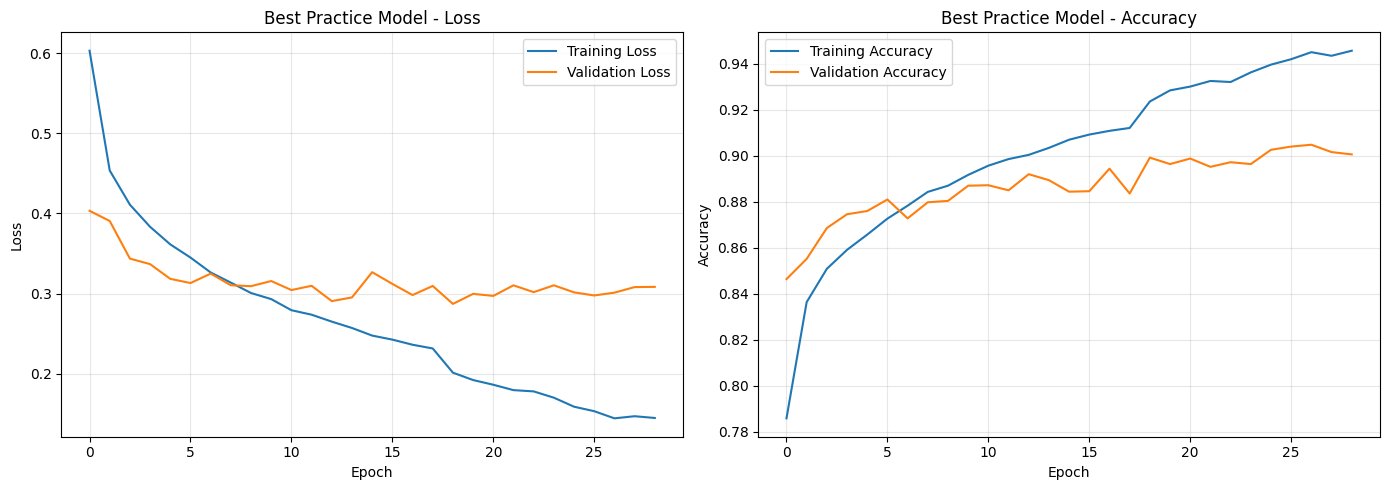

In [35]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_best.history['loss'], label='Training Loss')
axes[0].plot(history_best.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Best Practice Model - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_best.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_best.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Best Practice Model - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Kesimpulan

### Key Takeaways:

1. **Vanishing/Exploding Gradients** dapat diatasi dengan:
   - Proper weight initialization (He, Glorot)
   - Better activation functions (ReLU, ELU, SELU, Swish)
   - Batch Normalization

2. **Transfer Learning** memungkinkan reusing pretrained layers:
   - Feature extraction (freeze layers)
   - Fine-tuning (unfreeze top layers)

3. **Faster Optimizers**:
   - Momentum, Nesterov
   - Adam (default choice), AdamW
   - Learning rate scheduling

4. **Regularization Techniques**:
   - L1/L2 regularization
   - **Dropout** (paling populer)
   - Early stopping
   - Max-norm constraints

5. **Best Practices**:
   - He initialization + ReLU
   - Batch Normalization
   - Dropout (0.2-0.5)
   - Adam optimizer
   - Early stopping + LR scheduling

